In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
# read into files to get the data the jpeg files
path = 'archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/'
comics_path = path + 'comics/'
face_path = path + 'face/'

comics = []
face = []
for i in os.listdir(comics_path):
    comics.append(comics_path + i)

for i in os.listdir(face_path):
    face.append(face_path + i)

print(comics[0])
print(face[0])

archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics/0.jpg
archive/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/0.jpg


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# work on gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.set_device(0)
    print("Using GPU")

Using GPU


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Define the encoder (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        # Define the decoder (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
face_train = face[:8000]
comics_train = comics[:8000]

In [ ]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Custom dataset using the two lists
class PairedImageDataset(Dataset):
    def __init__(self, face_paths, comic_paths, transform=None):
        self.face_paths = face_paths
        self.comic_paths = comic_paths
        self.transform = transform

    def __len__(self):
        return len(self.face_paths)

    def __getitem__(self, idx):
        face_image = Image.open(self.face_paths[idx]).convert("RGB")
        comic_image = Image.open(self.comic_paths[idx]).convert("RGB")
        
        if self.transform:
            face_image = self.transform(face_image)
            comic_image = self.transform(comic_image)
        
        return face_image, comic_image

# Assuming 'face' and 'comics' are your lists of image paths
paired_dataset = PairedImageDataset(face_paths=face_train, comic_paths=comics_train, transform=transform)
dataloader = DataLoader(paired_dataset, batch_size=16, shuffle=True)

# Initialize model, loss function, and optimizer
model = UNet().to(device)

# model.load_state_dict(torch.load('unet_model.pth'))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [16]:
# Training loop
num_epochs = 30
losses = []
for epoch in tqdm.tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for original, comic in dataloader:
        optimizer.zero_grad()
        original = original.to(device)
        comic = comic.to(device)
        output = model(original)
        loss = criterion(output, comic)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

  3%|▎         | 1/30 [01:11<34:44, 71.89s/it]

Epoch [1/30], Loss: 0.1178


  7%|▋         | 2/30 [02:23<33:28, 71.73s/it]

Epoch [2/30], Loss: 0.0946


 10%|█         | 3/30 [03:35<32:17, 71.74s/it]

Epoch [3/30], Loss: 0.0832


 13%|█▎        | 4/30 [04:47<31:05, 71.74s/it]

Epoch [4/30], Loss: 0.0736


 17%|█▋        | 5/30 [05:58<29:51, 71.66s/it]

Epoch [5/30], Loss: 0.0654


 20%|██        | 6/30 [07:10<28:38, 71.60s/it]

Epoch [6/30], Loss: 0.0584


 23%|██▎       | 7/30 [08:21<27:27, 71.64s/it]

Epoch [7/30], Loss: 0.0521


 27%|██▋       | 8/30 [09:33<26:15, 71.61s/it]

Epoch [8/30], Loss: 0.0466


 30%|███       | 9/30 [10:44<25:03, 71.62s/it]

Epoch [9/30], Loss: 0.0418


 33%|███▎      | 10/30 [11:57<23:55, 71.78s/it]

Epoch [10/30], Loss: 0.0376


 37%|███▋      | 11/30 [13:12<23:06, 73.00s/it]

Epoch [11/30], Loss: 0.0338


 40%|████      | 12/30 [14:23<21:43, 72.42s/it]

Epoch [12/30], Loss: 0.0307


 43%|████▎     | 13/30 [15:35<20:24, 72.02s/it]

Epoch [13/30], Loss: 0.0277


 47%|████▋     | 14/30 [16:46<19:09, 71.84s/it]

Epoch [14/30], Loss: 0.0253


 50%|█████     | 15/30 [17:57<17:53, 71.59s/it]

Epoch [15/30], Loss: 0.0231


 53%|█████▎    | 16/30 [19:15<17:10, 73.62s/it]

Epoch [16/30], Loss: 0.0213


 57%|█████▋    | 17/30 [20:38<16:34, 76.50s/it]

Epoch [17/30], Loss: 0.0197


 60%|██████    | 18/30 [21:50<14:58, 74.89s/it]

Epoch [18/30], Loss: 0.0193


 63%|██████▎   | 19/30 [23:01<13:32, 73.89s/it]

Epoch [19/30], Loss: 0.0175


 67%|██████▋   | 20/30 [24:12<12:09, 72.95s/it]

Epoch [20/30], Loss: 0.0167


 70%|███████   | 21/30 [25:23<10:51, 72.44s/it]

Epoch [21/30], Loss: 0.0161


 73%|███████▎  | 22/30 [26:34<09:36, 72.08s/it]

Epoch [22/30], Loss: 0.0149


 77%|███████▋  | 23/30 [27:46<08:22, 71.80s/it]

Epoch [23/30], Loss: 0.0149


 80%|████████  | 24/30 [28:57<07:09, 71.63s/it]

Epoch [24/30], Loss: 0.0155


 83%|████████▎ | 25/30 [30:08<05:56, 71.39s/it]

Epoch [25/30], Loss: 0.0145


 83%|████████▎ | 25/30 [30:14<06:02, 72.60s/it]


KeyboardInterrupt: 

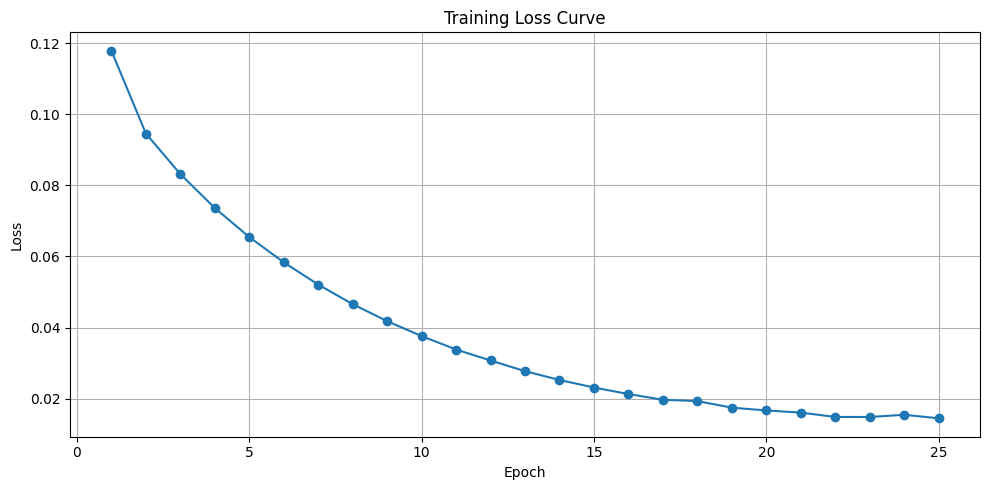

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25+1), losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
face_test = face[8000:]
comics_test = comics[8000:]

In [39]:
test_dataset = PairedImageDataset(face_paths=face_test, comic_paths=comics_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [42]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for original, comic in test_loader:
        original = original.to(device)
        comic = comic.to(device)
        output = model(original)
        loss = criterion(output, comic)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.0173


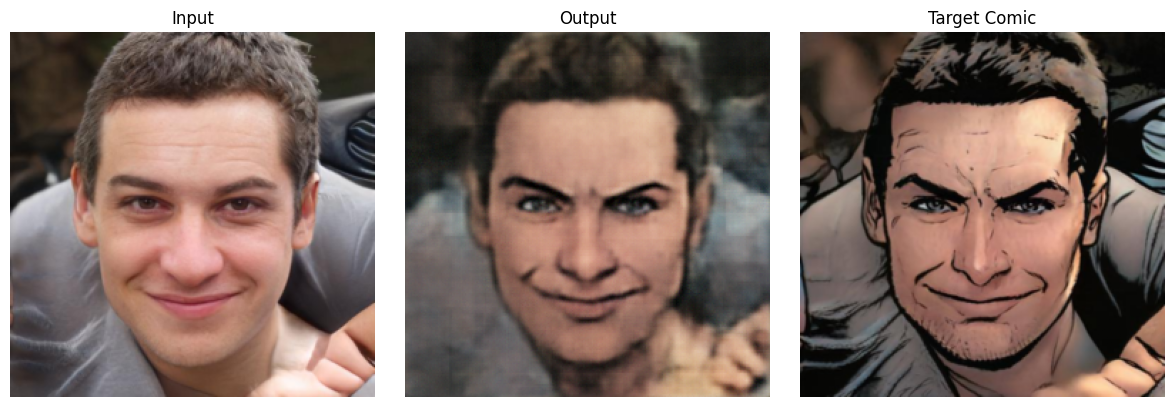

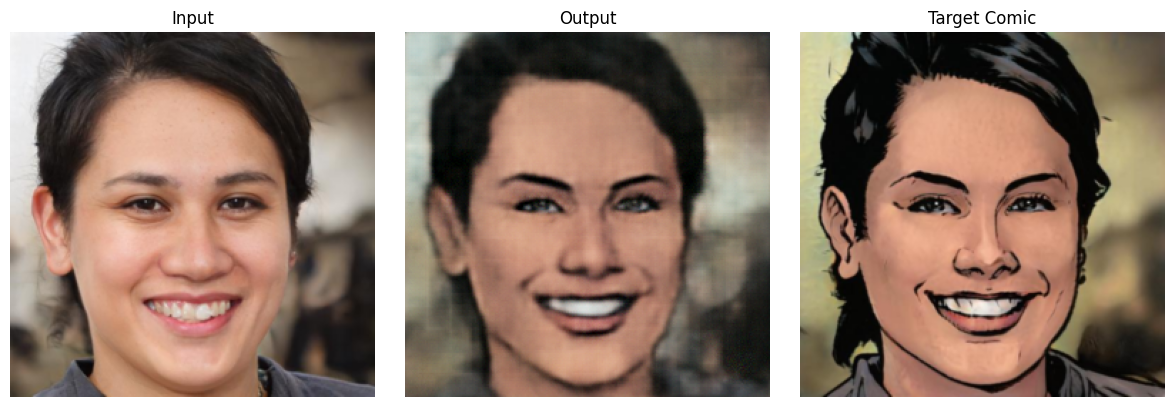

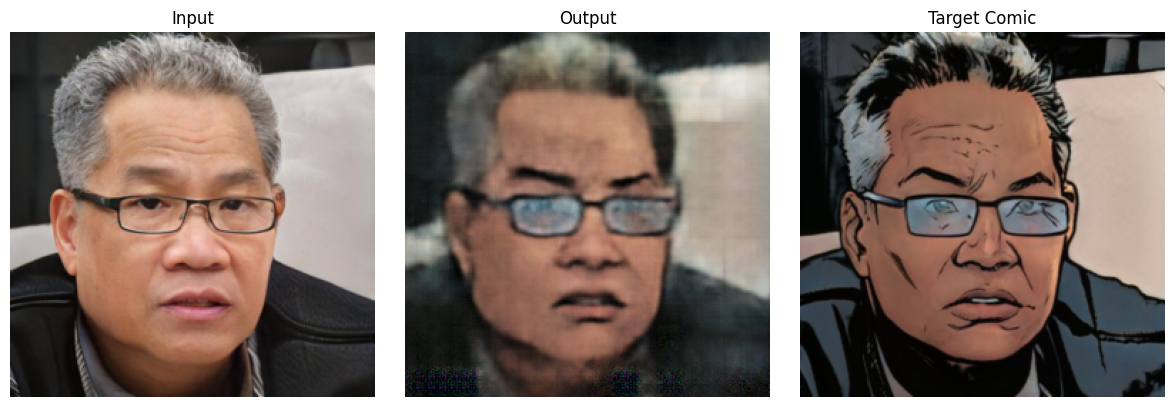

In [43]:
import matplotlib.pyplot as plt

original = original.cpu()
comic = comic.cpu()
output = output.cpu()

for i in range(3):  # Show first 3 results in batch
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original[i].permute(1, 2, 0))
    axs[0].set_title("Input")
    axs[1].imshow(output[i].permute(1, 2, 0).clamp(0, 1))  # Clamp if needed
    axs[1].set_title("Output")
    axs[2].imshow(comic[i].permute(1, 2, 0))
    axs[2].set_title("Target Comic")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# save the model
# torch.save(model.state_dict(), 'unet_model.pth')

In [52]:
lab_test = Image.open('Lab_Test2.jpg').convert("RGB")

In [53]:
out = model(transform(lab_test).to(device).reshape(1, 3, 256, 256))
out = out.cpu().detach().numpy().reshape(3, 256, 256)
out = out.transpose(1, 2, 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9731911].


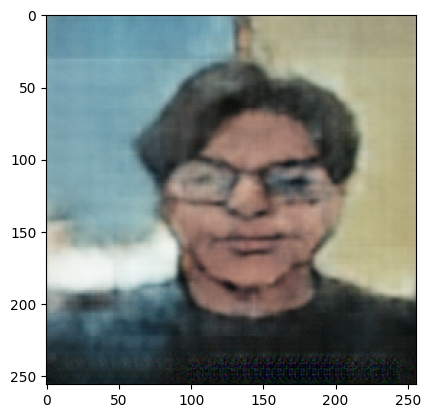

In [54]:
plt.imshow(out)

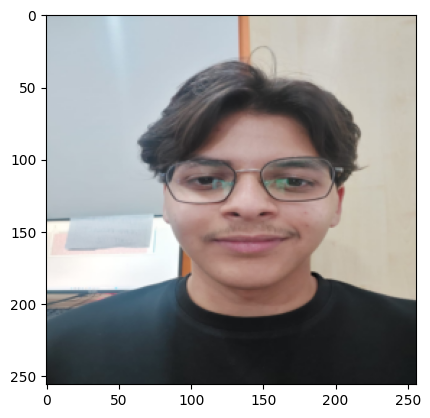

In [58]:
plt.imshow(transform(lab_test).cpu().detach().numpy().transpose(1, 2, 0))

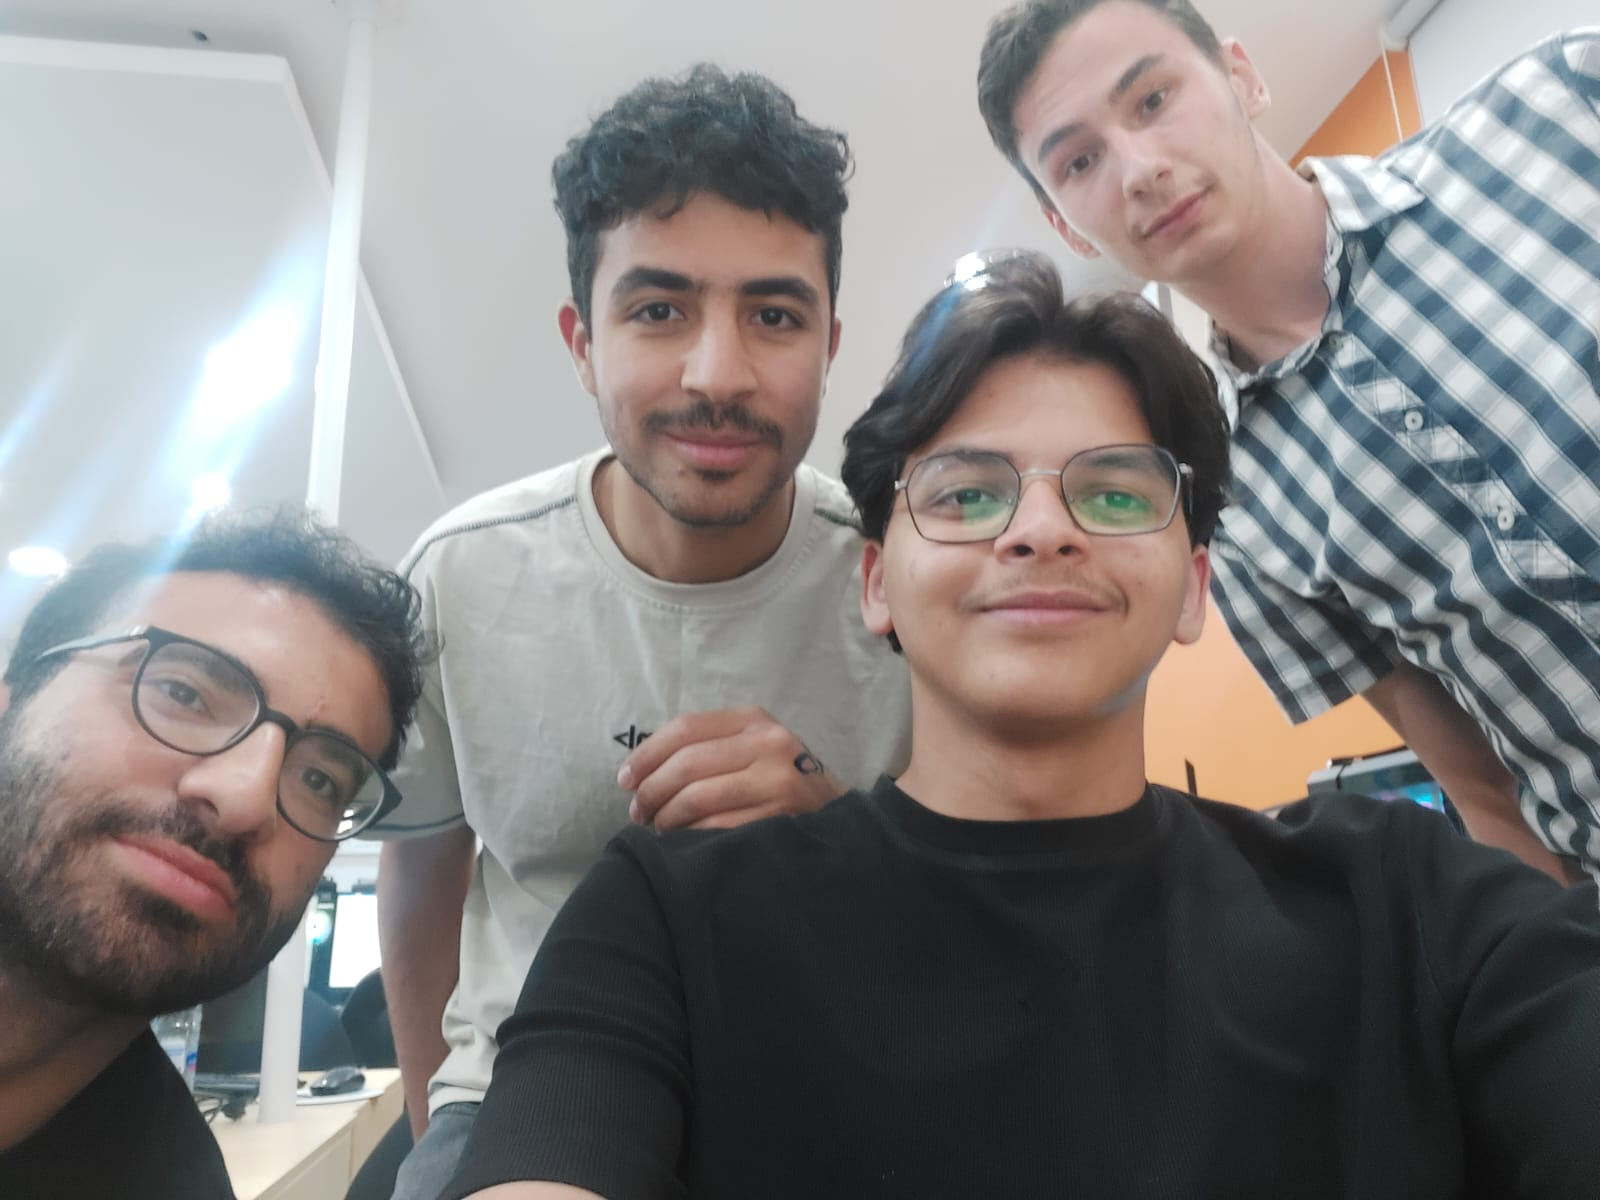

In [51]:
lab_test